In [1]:
input('Warning: contains solution spoilers. Press enter to continue.')
import numpy as np
import matplotlib.pyplot as plt

# Problem set 4
## Question 1

We should get waves moving to the right at speed $u$. For part c, we need IC as specified (sin, saw etc), no boundary on right (since waves "escape"), and a wave input on the left (Dirichlet $\phi(x=0)=\sin(-2\pi u t)$ for instance).

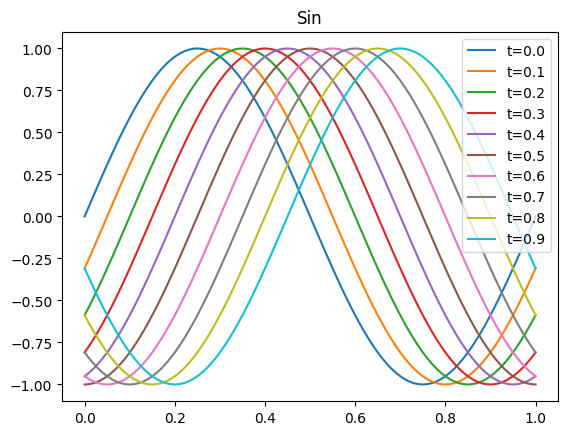

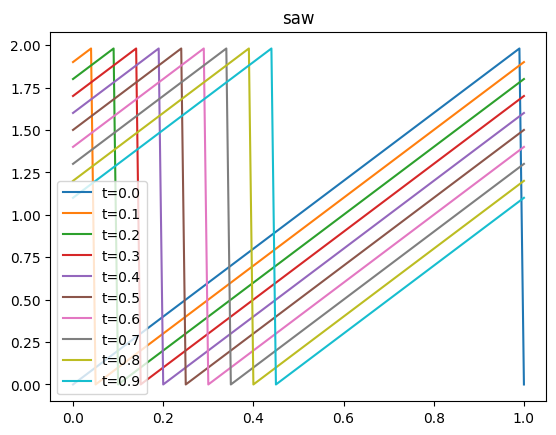

In [2]:
u = .5
dx = 0.01
Lx = 1.
x = np.arange(0, Lx+dx, dx)
sin_ic = lambda x: np.sin(2*np.pi*x)
saw_ic = lambda x: 2*x - 2*np.floor(x)

plt.title('Sin')
for i in range(10):
    t = i/10
    plt.plot(x, sin_ic(x-u*t), label='t={}'.format(t))
plt.legend()
plt.show()
plt.title('saw')
for i in range(10):
    t = i/10
    plt.plot(x, saw_ic(x-u*t), label='t={}'.format(t))
plt.legend()
plt.show()

## Question 2

In [3]:
def upwind(ic, bc=None, u=.5, dx=0.01, L=1, dt=0.01, T=1, snapshots=[]):
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    if bc is None:
        bc = lambda t: 0

    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC
    phi = np.array(ic(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = u*dt/dx
    
    # Matrix for upwind
    M = (1-dtdx)*np.identity(n) + \
        dtdx*np.diag([1]*(n-1), -1) 

    # Enforce BC
    M[0,0] = 0.

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # upwind step
        phi[0] = bc(-t*u)  # enforce BC

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return x, ts, phi_list


def plot_phis(x, ts, phi_list):
    colors = plt.cm.magma(np.linspace(0, 1, len(phi_list)))
    for i, phi in enumerate(phi_list):
        plt.plot(x, phi, label=f"{ts[i]:.2f}", color=colors[i])
    plt.legend(loc='upper right')


We can feed a constant dirichlet bc on the left...

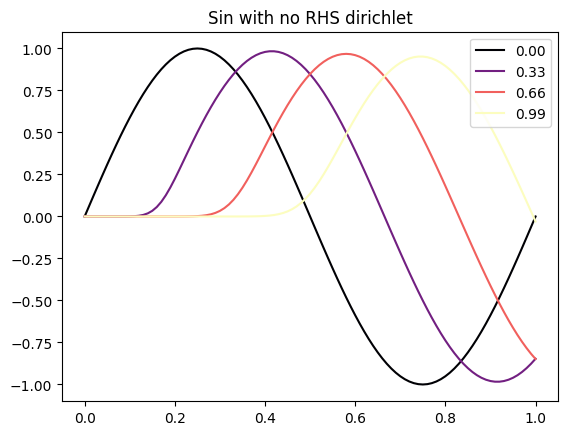

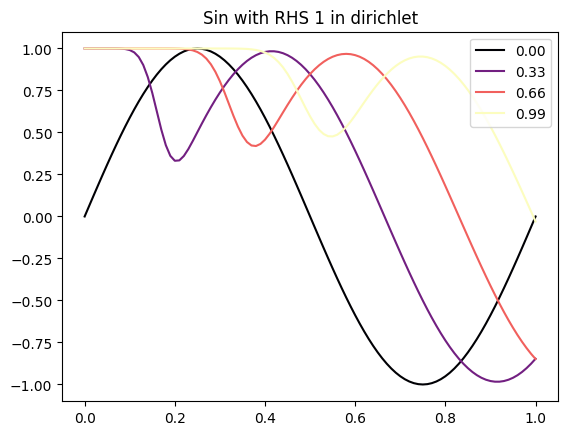

In [4]:
plt.title('Sin with no RHS dirichlet')
out = upwind(sin_ic, u=.5, dx=0.01, L=1, dt=0.01, T=1, snapshots=3)
plot_phis(*out)
plt.show()

plt.title('Sin with RHS 1 in dirichlet')
out = upwind(sin_ic, bc=lambda t:1, u=.5, dx=0.01, L=1, dt=0.01, T=1, snapshots=3)
plot_phis(*out)
plt.show()

With a varying bc (as asked in the question)...

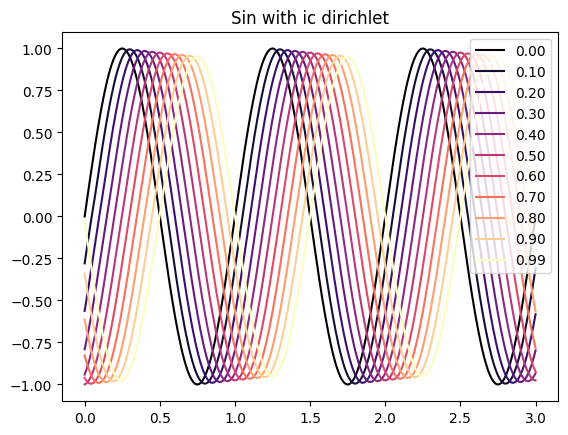

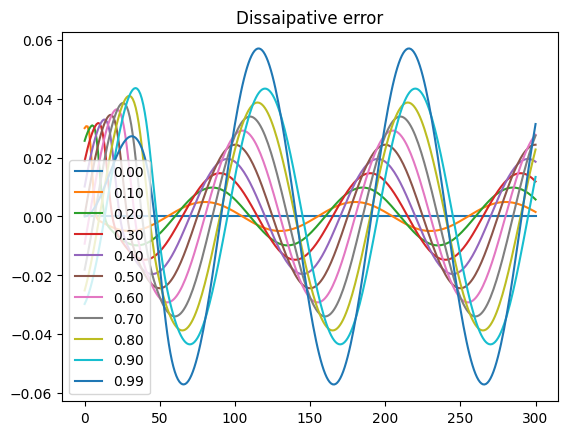

In [5]:
plt.title('Sin with ic dirichlet')
out = upwind(sin_ic, bc=sin_ic, u=.5, dx=0.01, L=3, dt=0.01, T=1, snapshots=10)
plot_phis(*out)
plt.show()

for i in range(len(out[2])):
    plt.title('Dissaipative error')
    plt.plot(out[2][i] - sin_ic(out[0]-u*out[1][i]), label=f"{out[1][i]:.2f}")
plt.legend()
plt.show()

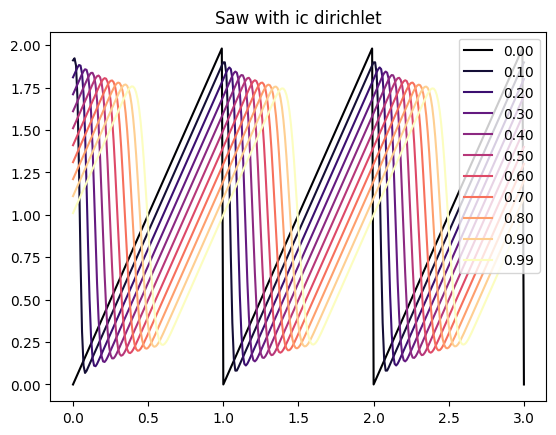

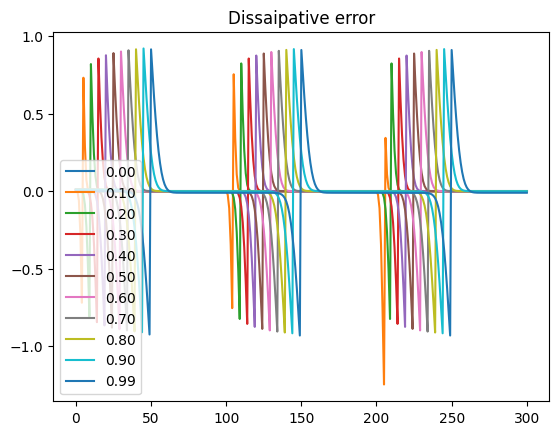

In [6]:
plt.title('Saw with ic dirichlet')
out = upwind(saw_ic, bc=saw_ic, u=.5, dx=0.01, L=3, dt=0.01, T=1, snapshots=10)
plot_phis(*out)
plt.show()

for i in range(len(out[2])):
    plt.title('Dissaipative error')
    plt.plot(out[2][i] - saw_ic(out[0]-u*out[1][i]), label=f"{out[1][i]:.2f}")
plt.legend()
plt.show()

Errors are much larger for sawtooth


Now lets mess around with $u$ to see shocks

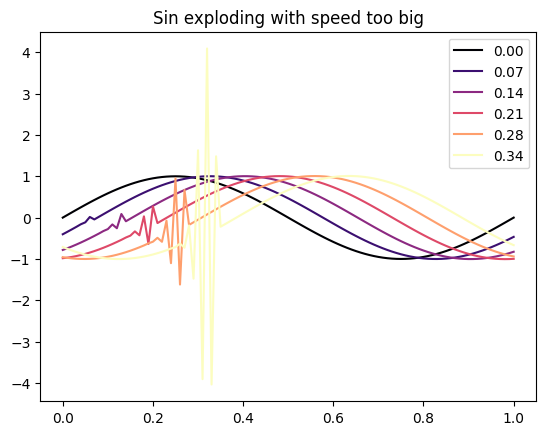

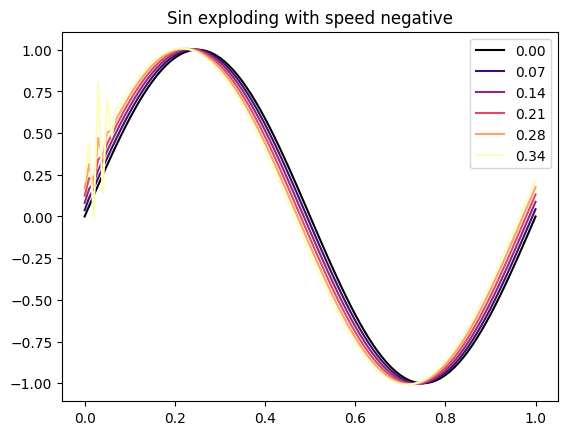

In [7]:
plt.title('Sin exploding with speed too big')
out = upwind(sin_ic, bc=sin_ic, u=1.1, dx=0.01, L=1, dt=0.01, T=.35, snapshots=5)
plot_phis(*out)
plt.show()

plt.title('Sin exploding with speed negative')
out = upwind(sin_ic, bc=sin_ic, u=-.1, dx=0.01, L=1, dt=0.01, T=.35, snapshots=5)
plot_phis(*out)
plt.show()

## Question 3

In [8]:
def ftcs(ic, bc=None, u=.5, dx=0.01, L=1, dt=0.01, T=1, snapshots=[]):
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    if bc is None:
        bc = lambda t: 0

    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC
    phi = np.array(ic(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = u*dt/(2*dx)
    
    # Matrix for ftcs
    M = np.identity(n) + \
        -dtdx*np.diag([1]*(n-1), 1) +\
        dtdx*np.diag([1]*(n-1), -1)

    # Enforce BC
    M[0,0] = 0.
    M[-1,-1] = 1- dt/dx * u

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # upwind step
        phi[0] = bc(-t*u)  # enforce BC

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return x, ts, phi_list

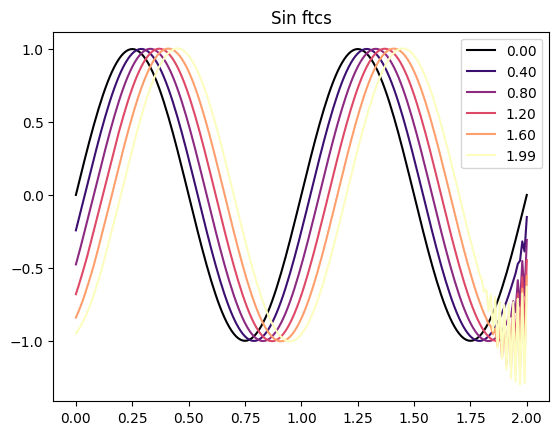

In [9]:
plt.title('Sin ftcs')
out = ftcs(sin_ic, bc=sin_ic, u=.1, dx=0.01, L=2, dt=0.01, T=2, snapshots=5)
plot_phis(*out)
plt.show()


## Question 4

In [10]:
def lf(ic, bc=None, u=.5, dx=0.01, L=1, dt=0.01, T=1, snapshots=[]):
    if isinstance(snapshots, int):
        Nt = int(T/dt)
        snapshots = np.arange(0, Nt, Nt//snapshots)
    if bc is None:
        bc = lambda t: 0

    # Time and space axis
    t_list = np.arange(0, T, dt, dtype=np.float64)
    x = np.arange(0, L+dx, dx, dtype=np.float64)
    
    # IC
    phi = np.array(ic(x), dtype=np.float64)
    
    phi_list = []
    ts = []
    
    n = len(x)
    dtdx = u*dt/(2*dx)
    
    # Matrix for ftcs
    M = (1/2-dtdx)*np.diag([1]*(n-1), 1) +\
        (1/2+dtdx)*np.diag([1]*(n-1), -1)

    # Enforce BC
    M[0,0] = 0.

    for i, t in enumerate(t_list):
        if i in snapshots:
            phi_list.append(phi)
            ts.append(t)
        phi = M@phi  # upwind step
        phi[0] = bc(-t*u)  # enforce BC

    if t not in ts:  # Save last snapshot
        phi_list.append(phi)
        ts.append(t)
    return x, ts, phi_list

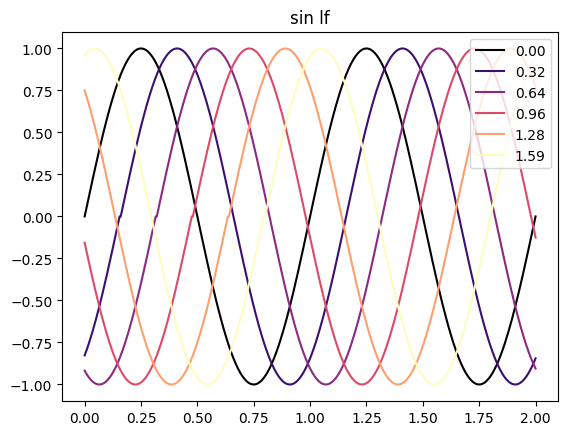

In [11]:
plt.title('sin lf')
out = lf(sin_ic, bc=sin_ic, u=.5, dx=0.005, L=2, dt=0.01, T=1.6, snapshots=5)
plot_phis(*out)
plt.show()


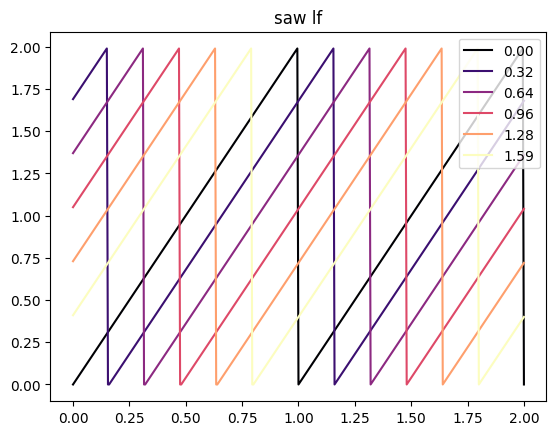

In [12]:
plt.title('saw lf')
out = lf(saw_ic, bc=saw_ic, u=.5, dx=0.005, L=2, dt=0.01, T=1.6, snapshots=5)
plot_phis(*out)
plt.show()


Looks a lot better!